In [2]:
from cycle_ratio import CycleRatio, read_graph, node_edge_count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import time
import networkx as nx


cycle_ratio = {}
degree_ratio = {}
coreness_ratio = {}
h_index_ratio = {}
corr_matrices = []

datasets = ['Email.txt', 'Jazz.txt', 'NS_GC.txt', 'Celegans.txt', 'USAir.txt', 'Yeast.txt']

In [3]:
for network in datasets:
    graph = read_graph(f'Dataset/{network}')
    node_count, edge_count = node_edge_count(graph=graph)
    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    all_nodes = list(graph.nodes())
    # Degree Ratio
    degree_ratio_data = dict(graph.degree)
    fixed_degree_ratio = degree_ratio_data.values()
    sorted_degree_ratio = sorted(degree_ratio_data.items(), key=lambda x:x[1])
    sorted_degree_ratio = list(reversed(sorted_degree_ratio))
    degree_ratio[network_name] = sorted_degree_ratio

    # Coreness Ratio
    coreness_ratio_data = nx.core_number(graph)
    fixed_coreness_ratio = coreness_ratio_data.values()
    sorted_coreness_ratio = sorted(coreness_ratio_data.items(), key=lambda x:x[1])
    sorted_coreness_ratio = list(reversed(sorted_coreness_ratio))
    coreness_ratio[network_name] = sorted_coreness_ratio
    
    # H-index Ratio
    h_index_ratio_data = {}
    for node in list(graph.nodes):
        sorted_neighbor_degrees = sorted((graph.degree(v) for v in graph.neighbors(node)), reverse=True)
        h = 0
        for i in range(1, len(sorted_neighbor_degrees)+1):
            if sorted_neighbor_degrees[i-1] < i:
                break
            h = i
        h_index_ratio_data[node] = h
    fixed_h_index_ratio = h_index_ratio_data.values()
    sorted_h_index_ratio = sorted(h_index_ratio_data.items(), key=lambda x:x[1])
    sorted_h_index_ratio = list(reversed(sorted_h_index_ratio))
    h_index_ratio[network_name] = sorted_h_index_ratio

    # Cycle Ratio
    cr = CycleRatio(graph=graph)
    cr.prune_graph()
    cr.getSmallestCycles()
    cr.StatisticsAndCalculateIndicators(network=network_name)
    fixed_cycle_ratio = []

    for node in all_nodes:
        fixed_cycle_ratio.append(cr.CycleRatio[node])
    
    sorted_cycle_ratio = sorted(cr.CycleRatio.items(), key=lambda x:x[1])
    sorted_cycle_ratio = list(reversed(sorted_cycle_ratio))
    cycle_ratio[network_name] = sorted_cycle_ratio

    df = pd.DataFrame(
        {
            'D': fixed_degree_ratio,
            'H': fixed_h_index_ratio,
            'C': fixed_coreness_ratio,
            'R': fixed_cycle_ratio,
        }
    )
    corr_matrices.append(df)

Processing Email network
Processing Jazz network
Processing NS_GC network
Processing Celegans network
Processing USAir network
Processing Yeast network


In [4]:
for df in corr_matrices:
    df['D'] = df['D'].rank(method='average')
    df['H'] = df['H'].rank(method='average')
    df['C'] = df['C'].rank(method='average')
    df['R'] = df['R'].rank(method='average')

correlation_matrices = [df[['D', 'H', 'C', 'R']].corr(method='kendall') for df in corr_matrices]

average_correlation_matrix = sum(correlation_matrices) / len(correlation_matrices)

In [6]:
average_correlation_matrix

,D,H,C,R
D,1.000000,0.903107,0.844854,0.676149
H,0.903107,1.000000,0.929608,0.590355
C,0.844854,0.929608,1.000000,0.542971
R,0.676149,0.590355,0.542971,1.000000


          D         H         C         R
D  1.000000  0.903107  0.844854  0.676149
H  0.903107  1.000000  0.929608  0.590355
C  0.844854  0.929608  1.000000  0.542971
R  0.676149  0.590355  0.542971  1.000000


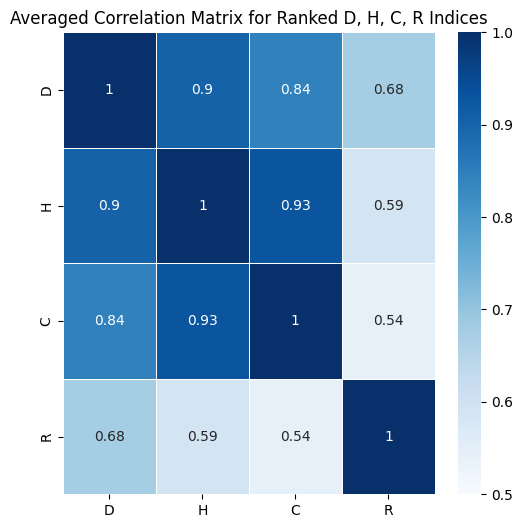

In [9]:
plt.figure(figsize=(6, 6))
sns.heatmap(average_correlation_matrix, annot=True, cmap='Blues', linewidths=.5, vmin=0.5, vmax=1.0)
plt.title("Averaged Correlation Matrix for Ranked D, H, C, R Indices")
plt.savefig('correlation_matrix.jpg')

print(average_correlation_matrix)
average_correlation_matrix.to_csv('correlation_matrix.csv', index=False)
plt.show()